Load Packages

In [27]:
import numpy
#from numba import njit
from matplotlib import pyplot
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.fftpack import fft, fftfreq
from matplotlib import rcParams

Class definition

In [28]:
class mesh():
    def __init__(self):
        self.x = []
        self.y = []
        self.z = []

class field():
    def __init__(self):
        self.U = []
        self.V = []
        self.W  = []
        self.P  = []
        self.T  = []
        
class volume():
    def __init__(self):
        self.time = []
        self.mesh = mesh()
        self.field = field()
        
        

Function definition

In [99]:
#####################################################################################################################
#@njit
def load_data(file_name,headers):
    """
    Load data from an external file.
    
    Arguments:
    ----------
    file_name (str) : name of the data file to load
    headers (int)   : row where data starts (skips headers).
    
    Returns:
    --------
    mesh (cell)     : volumes coordinates of the mesh:
                        - mesh.x
                        - mesh.y
                        - mesh.z
    field (field)   : Fields value at cells center:
                        - field.U
                        - field.V
                        - field.W
                        - field.P
                        - field.T

    """

    volume_aux = volume()
    
    data = numpy.loadtxt(fname=file_name,skiprows=headers)
    
    volume_aux.mesh.x = data[:,0]
    volume_aux.mesh.y = data[:,1]
    volume_aux.mesh.z = data[:,2]
    volume_aux.field.U = data[:,3]
    volume_aux.field.V = data[:,4]
    volume_aux.field.W = data[:,5]
    volume_aux.field.P = data[:,6]
    volume_aux.field.T = data[:,7]
    
    return volume_aux

#####################################################################################################################
#@njit
def load_monitoring_points_data(file_name):
    """
    load monitoring points data from an external file.
    
    Arguments:
    ----------
    file_name (str) : name of the data file to load
    
    Returns:
    --------
    mp_aux (volume)     : volumes coordinates of the mesh:
                            - mesh.x
                            - mesh.y
                            - mesh.z
    field (field)       : Fields value at cells center:
                            - field.U
                            - field.V
                            - field.W
                            - field.P
                            - field.T

    """

    mp_aux = volume()
    
    data = numpy.loadtxt(fname=file_name,skiprows=1)
    
    mp_aux.time = data[:,0]
    mp_aux.field.U = data[:,1]
    mp_aux.field.V = data[:,2]
    mp_aux.field.W = data[:,3]
    mp_aux.field.P = data[:,4]
    mp_aux.field.T = data[:,5]
    
    
    return mp_aux

#####################################################################################################################
#@njit
def slice_plane(data,a,b,c,d):
    """
    select data over the plane:
        pi : a*x + b*y + c*z = d.
    
    Arguments:
    ----------
    mesh  (mesh)                  : Mesh coordinates
    field (field)                 : Field to be sliced.
    a (real)                      : x-component of the plane's normal vector.
    b (real)                      : y-component of the plane's normal vector
    c (real)                      : z-component of the plane's normal vector
    d (real)                      : position parameter
    
    Returns:
    --------
    slice_out (ReturnSliceValue)  : filtered data:
                                      - slice_out.data
                                      - slice_out.x
                                      - slice_out.y
                                      - slice_out.z
    """
    
    volume_aux = volume()
    
    volume_aux.field.U = data.field.U[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.field.V = data.field.V[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.field.W = data.field.W[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.field.P = data.field.P[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.field.T = data.field.T[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]

    
    volume_aux.mesh.x = data.mesh.x[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.mesh.y = data.mesh.y[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.mesh.z = data.mesh.z[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]

    return volume_aux

#####################################################################################################################
#@njit
def monitoring_point(data,mp_,nmp_):
    """
    Select data over monitoring points.
    
    Arguments:
    ----------
    data (volume)            : Data loaded from hpts.out file:
                                      - data
                                          '-> .time []
                                      - data.mesh
                                          |-> .x []
                                          |-> .y []
                                          '-> .z []
                                      - data.field
                                          |-> .U []
                                          |-> .V []
                                          |-> .W []
                                          |-> .P []
                                          '-> .T []
    mp_ (integer)            : Id number from the desire monitoring point.
    nmp_ (integer)           : Total number of monitoring point.
    
    Returns:
    --------
    point_out (volume)            : Data from monitoring point:
                                      - point_out
                                          '-> .time []
                                      - point.mesh
                                          |-> .x []
                                          |-> .y []
                                          '-> .z []
                                      - point.field
                                          |-> .U []
                                          |-> .V []
                                          |-> .W []
                                          |-> .P []
                                          '-> .T []

    """
    
    point_aux = volume()
    
    point_aux.time = mp_data.time[mp_::nmp_]
    
    point_aux.field.U = mp_data.field.U[mp_::nmp_]
    point_aux.field.V = mp_data.field.V[mp_::nmp_]
    point_aux.field.W = mp_data.field.W[mp_::nmp_]
    point_aux.field.P = mp_data.field.P[mp_::nmp_]
    point_aux.field.T = mp_data.field.T[mp_::nmp_]
    
    point_out = point_aux

    return point_out

#####################################################################################################################
#@njit
def plot_3d(abs_,ord_,field_,data,number_of_level,scale_factor):
    
    if abs_ == "x":
        x = data.mesh.x
        pyplot.xlabel('x [-]')
    elif abs_ == "y":
        x = data.mesh.y
        pyplot.xlabel('y [-]')
    else:
        x = data.mesh.z
        pyplot.xlabel('z [-]')
        
    if ord_ == "x":
        y = data.mesh.x
        pyplot.ylabel('x [-]')
    elif ord_ == "y":
        y = data.mesh.y
        pyplot.ylabel('y [-]')
    else:
        y = data.mesh.z
        pyplot.ylabel('z [-]')
    
    if field_ == "U":
        field = data.field.U
    elif field_ == "V":
        field = data.field.V
    elif field_ == "W":
        field = data.field.W
    elif field_ == "P":
        field = data.field.P
    else:
        field = data.field.T
    
    #pyplot.figure(figsize=(max(x)*scale_factor,max(y)*scale_factor))
    
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 14
    
    delta=1e-11
    
    pyplot.figure(figsize=(max(x)*scale_factor,max(y)*scale_factor))
    x_ticks = numpy.arange(min(x), max(x)+delta, (max(x)-min(x))/5)
    y_ticks = numpy.arange(min(y), max(y)+delta, (max(y)-min(y))/5)
    resolution = numpy.arange(min(field), max(field)+delta, (max(field)-min(field))/10)
    iso_levels = numpy.arange(min(field), max(field), (max(field)-min(field))/number_of_level)
    pyplot.title('Reduced Temperature at mid-large plane. \n')
    pyplot.xlim([min(x),max(x)])
    pyplot.ylim([min(y),max(y)])
    pyplot.xticks(x_ticks, rotation=75)
    pyplot.yticks(y_ticks)
    pyplot.grid()
    pyplot.tricontourf(x,y,field,
                       levels = resolution,
                       cmap='coolwarm')    
    pyplot.colorbar()
    pyplot.tricontour(x,y,field,
                      levels = iso_levels,
                      ls='-.',
                      lw=2,
                      colors='black');
    pyplot.savefig(abs_+ord_+field_+'.eps')
    return

#####################################################################################################################
#@njit
def plot_over_line(abs_,field_,data,scale_factor):
    
    pyplot.figure(figsize=(2*scale_factor,1*scale_factor));
    if abs_ == "x":
        x = data.mesh.x
        pyplot.xlabel('x [-]')
    elif abs_ == "y":
        x = data.mesh.y
        pyplot.xlabel('y [-]')
    else:
        x = data.mesh.z
        pyplot.xlabel('z [-]')
    
    if field_ == "U":
        y = data.field.U
        pyplot.ylabel('Dimensionless X-Velocity [-]')
    elif field_ == "V":
        y = data.field.V
        pyplot.ylabel('Dimensionless Y-Velocity [-]')
    elif field_ == "W":
        y = data.field.W
        pyplot.ylabel('Dimensionless W-Velocity [-]')
    elif field_ == "P":
        y = data.field.P
        pyplot.ylabel('Dimensionless Pressure [-]')        
    else:
        y = data.field.T
        pyplot.ylabel('Dimensionless Temperature [-]')

    
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 14
    
    delta=1e-11
    
    x_ticks = numpy.arange(min(x), max(x)+delta, (max(x)-min(x))/10)
    y_ticks = numpy.arange(min(y), max(y)+delta, (max(y)-min(y))/10)
    
    x,y = zip(*sorted(zip(x,y)))
    
#    pyplot.title('Reduced Temperature at mid-large plane. \n')
#    pyplot.xlabel('x [-]')
#    pyplot.ylabel('z [-]')
    pyplot.xlim([min(x),max(x)])
    pyplot.ylim([min(y)*1.1,max(y)*1.1])
    pyplot.xticks(x_ticks, rotation=75)
    pyplot.yticks(y_ticks)
    pyplot.grid()
    pyplot.plot(x,y,
                color='#2929e3',
                ls='-',
                lw=1)
    #pyplot.colorbar()
    pyplot.savefig(abs_+field_+'.eps')
    return

#####################################################################################################################
#@njit
def plot_over_time(point_,field_,scale_factor):
    
    pyplot.figure(figsize=(2*scale_factor,1*scale_factor));
    
    if field_ == "U":
        y = point_.field.U
        pyplot.ylabel('Dimensionless X-Velocity [-]')
    elif field_ == "V":
        y = point_.field.V
        pyplot.ylabel('Dimensionless Y-Velocity [-]')
    elif field_ == "W":
        y = point_.field.W
        pyplot.ylabel('Dimensionless Z-Velocity [-]')
    elif field_ == "P":
        y = point_.field.P
        pyplot.ylabel('Dimensionless Pressure [-]')        
    else:
        y = point_.field.T
        pyplot.ylabel('Dimensionless Temperature [-]')
    
    x = point_.time
    pyplot.xlabel('Dimensionless Time [-]')

    
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 14
    
    delta=1e-15
    
    x_ticks = numpy.arange(min(x), max(x)+delta, (max(x)-min(x))/10)
    y_ticks = numpy.arange(min(y), max(y)+delta, (max(y)-min(y))/10)
    
    #x,y = zip(*sorted(zip(x,y)))
    

    pyplot.xlim([min(x),max(x)])
    pyplot.ylim([min(y)*1.1,max(y)*1.1])
    pyplot.xticks(x_ticks, rotation=75)
    pyplot.yticks(y_ticks)
    pyplot.grid()
    pyplot.plot(x,y,
                color='#2929e3',
                ls='-',
                lw=1)
    pyplot.savefig('mp'+field_+'.eps')
    return

Main program

In [105]:
def main():
    
    # Determinar la fila donde comienza la data
    #!head -n 411 high_ray.fld02 | tail -n 4
    
    #data = load_data('high_ray.fld02',409)
    #mp_data = load_monitoring_points_data("hpts.out")
    #data_rms = load_data('rmshigh_ray.fld08',409)
    #data_avg = load_data('avghigh_ray.fld08',409)
    
    plane_1 = slice_plane(data,0,1,0,0)
    
    plot_3d("x","z","T",plane_1,10,30)
    #plot_3d("x","z","W",plane_1,10,30)
    
    line_1 = slice_plane(slice_plane(data,0,1,0,0),0,0,1,0)
    line_2 = slice_plane(slice_plane(data,0,1,0,0),1,0,0,0)    

    
    plot_over_line("x","T",line_1,5)
    plot_over_line("x","W",line_1,5)
    plot_over_line("z","T",line_2,5)
    
    point_1 = monitoring_point(mp_data,1,5)
    
    #plot_over_time(point_1,"U",5)
    #plot_over_time(point_1,"V",5)
    plot_over_time(point_1,"W",5)
    #plot_over_time(point_1,"P",5)
    plot_over_time(point_1,"T",5)
    
    
    return data,mp_data

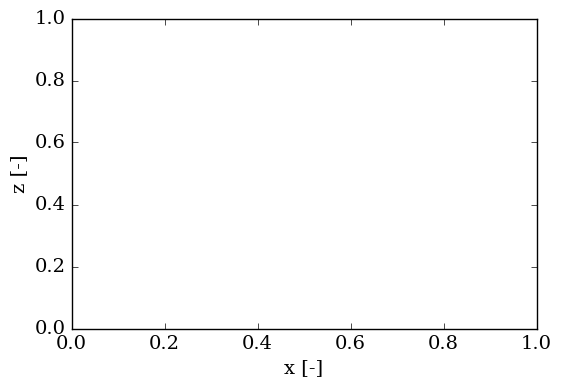

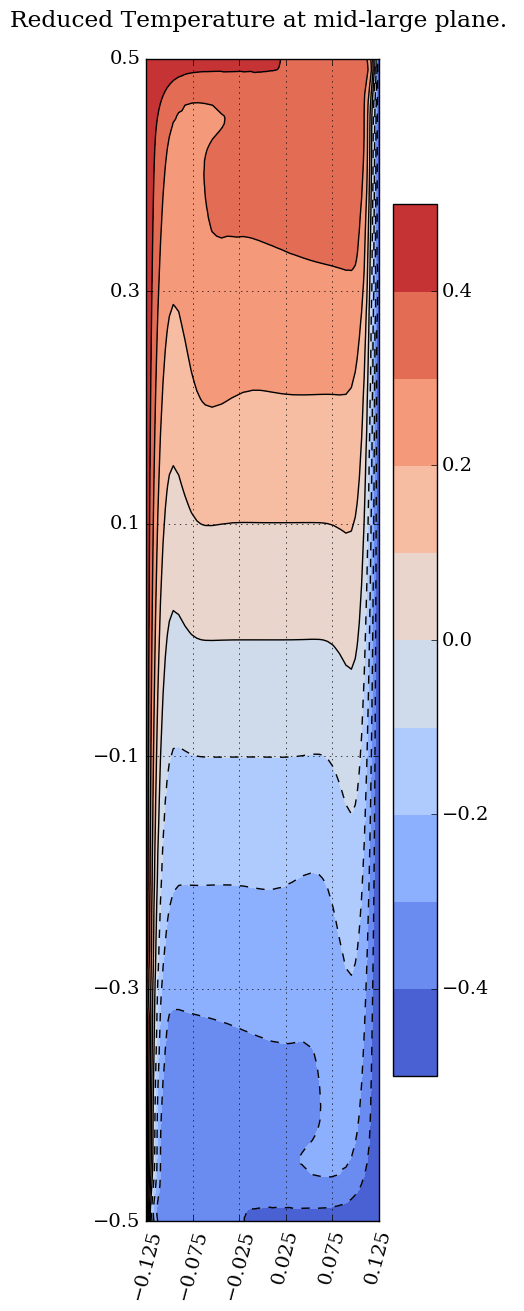

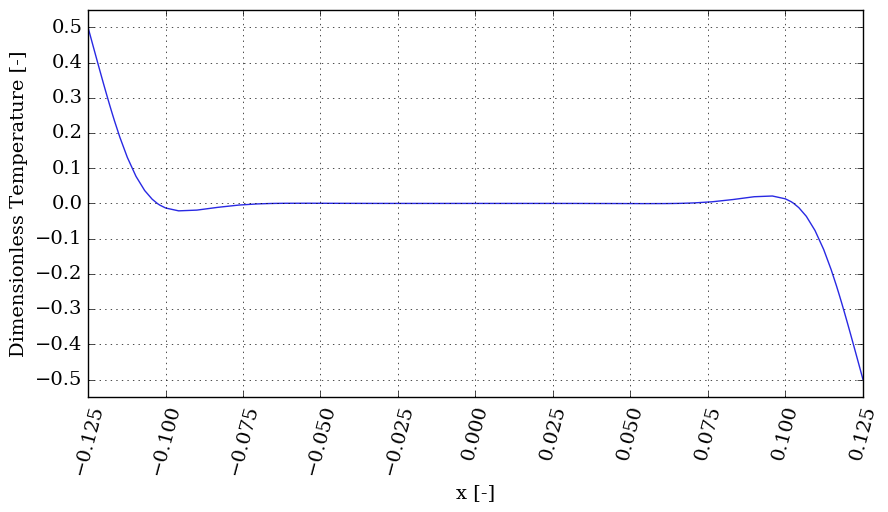

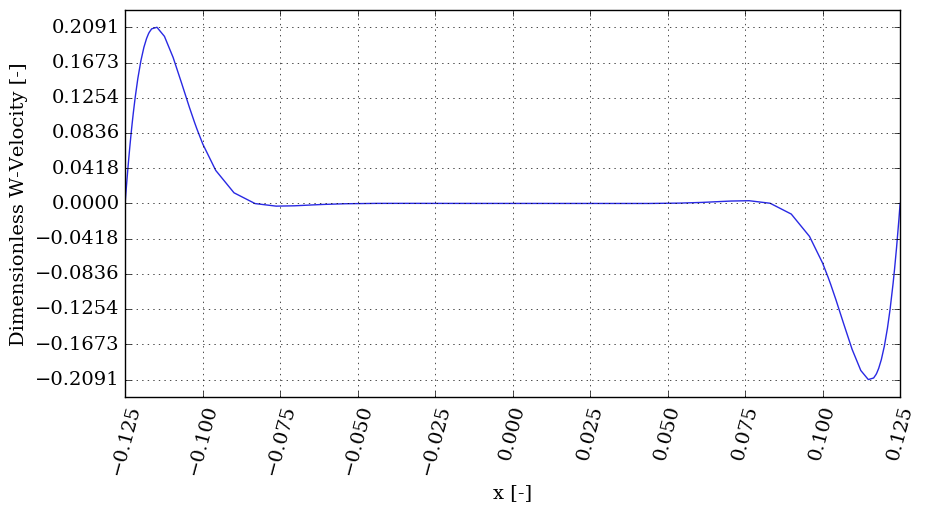

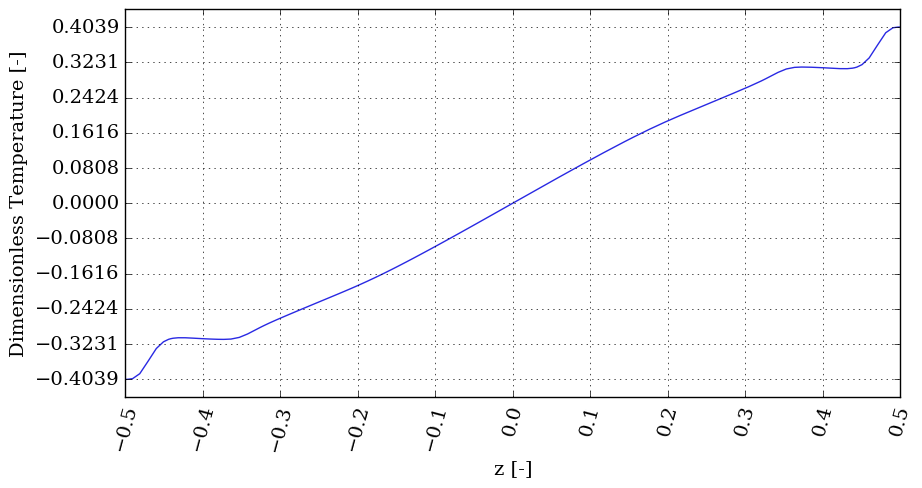

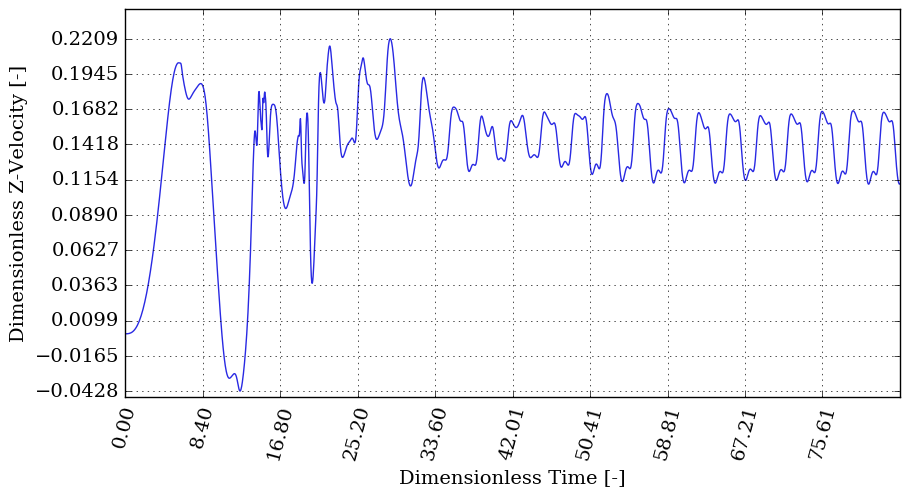

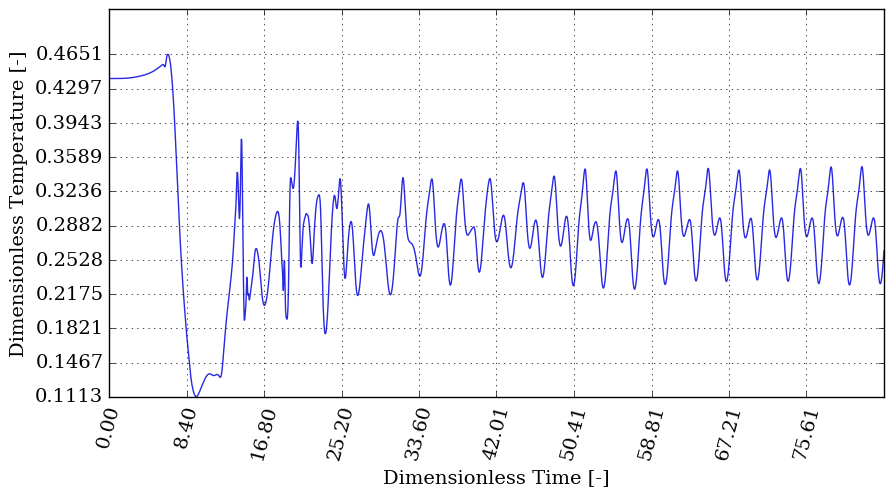

In [106]:
data,mp_data = main()
#main();
